In [1]:
import os
import sys
import yaml

# Path to the dataset zip file
data_folder = "./data"


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

In [2]:
from examples.minv.celebA.utils.celebA_data import get_celebA_dataloader

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), train_config["data"]["data_dir"])

#print(train_config)

train_loader, test_loader = get_celebA_dataloader(path, train_config)

Load data from ./data/celebaA_data.pkl


In [ ]:
# Plot an image from train_loader
import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
found = False
while not found:
    images, labels = next(iter(train_loader))
    labels = labels.numpy()
    for i in range(len(labels)):
        if labels[i] == 0:
            print(labels[i])
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            plt.show()
            found = True
            break


In [3]:
from examples.mia.celebA_HQ.utils.celeb_hq_model import ResNet18
from examples.mia.celebA_HQ.utils.celeb_hq_model import create_trained_model_and_metadata
# Get number of classes from the train_loader
num_classes = train_loader.dataset.dataset.get_classes()
print(num_classes)

# Create the model
model = ResNet18(num_classes=num_classes)

# Load the model
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,train_loader,test_loader, train_config)



500


Training Progress: 100%|██████████| 5/5 [06:32<00:00, 78.50s/it]


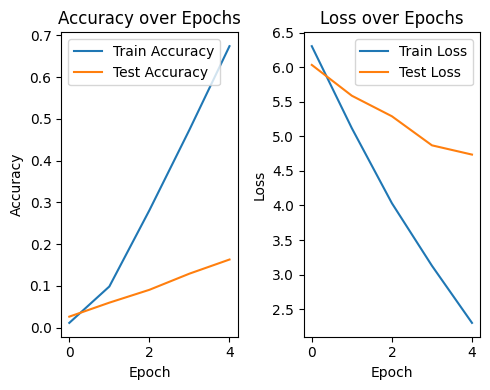

In [5]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Model Inversion Attack on Identifier Model 

In [ ]:
# TODO: Write code for our handler
#       Write audit.yaml

# Import input handler
#from examples.mia.celebA_HQ.utils.celeb_hq_input_handler import CelebAHQInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
#leakpro = LeakPro(CelebAHQInputHandler, config_path)

# Run the audit 
#mia_results = leakpro.run_audit(return_results=True)
